In [1]:
import sys
import os
current_dir = os.getcwd()  #use to import the defined functions
parent_dir = os.path.dirname(current_dir) 
sys.path.append(parent_dir)  

"""
incase the above code does not work, you can use the absolute path instead
sys.path.append(r".\")
"""


'\nincase the above code does not work, you can use the absolute path instead\nsys.path.append(r".")\n'

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau 

from utils.plot_utils import plot_kde_2d
from utils.basic_utils import setup_seed, sample_noise
from data.SimulationData import DataGenerator, generate_multi_responses_multiY
from utils.training_utils import train_WGR_fnn
from utils.evaluation_utils import L1L2_MSE_mean_sd_G, MSE_quantile_G_multiY
from models.generator import generator_fnn
from models.discriminator import discriminator_fnn



In [3]:
import argparse


if 'ipykernel_launcher.py' in sys.argv[0]:  #if not work in jupyter, you can delete this part
    import sys
    sys.argv = [sys.argv[0]] 


parser = argparse.ArgumentParser(description='Implementation of WGR for M1')

parser.add_argument('--Xdim', default=1, type=int, help='dimensionality of X')
parser.add_argument('--Ydim', default=2, type=int, help='dimensionality of Y')
parser.add_argument('--model', default='M3', type=str, help='model')

parser.add_argument('--noise_dim', default=10, type=int, help='dimensionality of noise vector')
parser.add_argument('--noise_dist', default='gaussian', type=str, help='distribution of noise vector')

parser.add_argument('--train', default=5000, type=int, help='size of train dataset')
parser.add_argument('--val', default=1000, type=int, help='size of validation dataset')
parser.add_argument('--test', default=1000, type=int, help='size of test dataset')

parser.add_argument('--train_batch', default=128, type=int, metavar='BS', help='batch size while training')
parser.add_argument('--val_batch', default=100, type=int, metavar='BS', help='batch size while validation')
parser.add_argument('--test_batch', default=100, type=int, metavar='BS', help='batch size while testing')
parser.add_argument('--epochs', default=100, type=int, help='number of epochs to train')
parser.add_argument('--reps', default=100, type=int, help='number of replications')

args = parser.parse_args()

print(args)

Namespace(Xdim=1, Ydim=2, model='M3', noise_dim=10, noise_dist='gaussian', train=5000, val=1000, test=1000, train_batch=128, val_batch=100, test_batch=100, epochs=100, reps=100)


In [4]:
setup_seed(5678)

In [5]:
# Generate data from M3
data_gen = DataGenerator(args)
DATA = data_gen.generate_data('M3')

train_X, train_Y = DATA['train_X'], DATA['train_Y']
val_X, val_Y = DATA['val_X'], DATA['val_Y']
test_X, test_Y = DATA['test_X'], DATA['test_Y']

In [6]:
# Create TensorDatasets and initialize a DataLoaders
train_dataset = TensorDataset( train_X.float(), train_Y.float() )
loader_train = DataLoader(train_dataset , batch_size=args.train_batch, shuffle=True)

val_dataset = TensorDataset( val_X.float(), val_Y.float() )
loader_val = DataLoader(val_dataset , batch_size=args.val_batch, shuffle=True)

test_dataset = TensorDataset( test_X.float(), test_Y.float() )
loader_test  = DataLoader(test_dataset , batch_size=args.test_batch, shuffle=True)

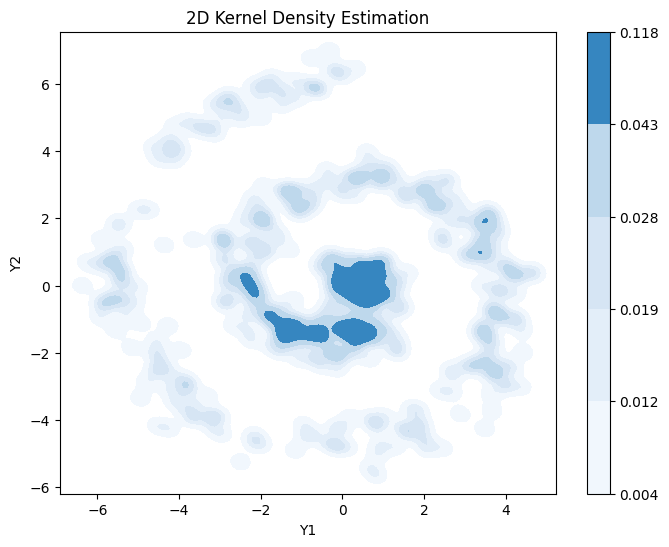

In [7]:
# Generate multiple response samples for visualization of the conditional distribution
# - Takes the first training sample and uses it as the conditioning value
plot_Y = generate_multi_responses_multiY(x_value = train_X[1].view([1]).item(), n_responses=500,model_type=args.model)
# Create a 2D kernel density estimation plot to visualize the distribution of responses
fig, ax = plot_kde_2d(plot_Y, title="2D Kernel Density Estimation")
plt.show()
plt.close()

In [8]:
# Define generator network and discriminator network
G_net = generator_fnn(Xdim=args.Xdim, Ydim=args.Ydim, noise_dim=args.noise_dim, hidden_dims = [512, 512, 512])
D_net = discriminator_fnn(input_dim=args.Xdim+args.Ydim, hidden_dims = [512, 512, 512])

In [9]:
D_solver = optim.RMSprop(D_net.parameters(),lr = 0.0002)
G_solver = optim.RMSprop(G_net.parameters(),lr = 0.0002)

Mean L1 Loss per dimension: tensor([2.2177, 2.2293])
Mean L2 Loss per dimension: tensor([7.6179, 7.8944])
Epoch 0 - D Loss: 0.6214, G Loss: 0.1991
Epoch 1 - D Loss: -0.6144, G Loss: 0.5958
Epoch 2 - D Loss: -0.4883, G Loss: 0.5812
Epoch 3 - D Loss: -0.4511, G Loss: 0.6644
Epoch 4 - D Loss: -0.3177, G Loss: 0.7377
Epoch 5 - D Loss: -0.2992, G Loss: 0.8432
Epoch 6 - D Loss: -0.0254, G Loss: 0.4047
Epoch 7 - D Loss: 0.0777, G Loss: 0.8186
Epoch 8 - D Loss: 0.0460, G Loss: 0.8359
Epoch 9 - D Loss: 0.0323, G Loss: 0.7193
Epoch 10 - D Loss: 0.0430, G Loss: 0.7327
Epoch 11 - D Loss: 0.0286, G Loss: 0.6474
Epoch 12 - D Loss: 0.0260, G Loss: 0.5537
Epoch 13 - D Loss: 0.0366, G Loss: 0.4512
Epoch 14 - D Loss: 0.0375, G Loss: 0.4009
Epoch 15 - D Loss: 0.0455, G Loss: 0.4407
Epoch 16 - D Loss: 0.0550, G Loss: 0.4918
Epoch 17 - D Loss: 0.0561, G Loss: 0.4983
Epoch 18 - D Loss: 0.0610, G Loss: 0.5881
Epoch 19 - D Loss: 0.0608, G Loss: 0.6295
Epoch 20 - D Loss: 0.0437, G Loss: 0.7010
Epoch 21 - D Los

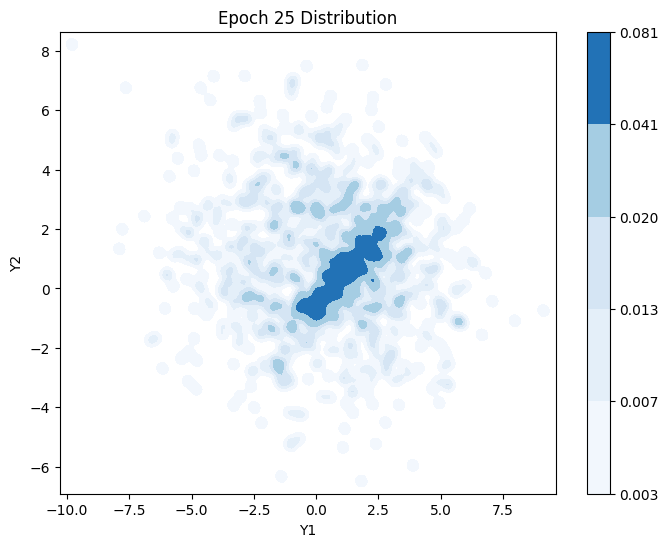

New best multivariate model with L2: 6.6832
Epoch 25 - D Loss: 0.0263, G Loss: 0.7816
Mean L1 Loss per dimension: tensor([2.0120, 2.1094])
Mean L2 Loss per dimension: tensor([6.4423, 7.1064])
Epoch 26, Iter 1050, D Loss: 0.0421, G Loss: 0.7583, L1: 2.0607, L2: 6.7744
Epoch 26 - D Loss: 0.0444, G Loss: 0.7543
Epoch 27 - D Loss: 0.0220, G Loss: 0.7926
Mean L1 Loss per dimension: tensor([2.0522, 2.0403])
Mean L2 Loss per dimension: tensor([6.4716, 6.9170])
Epoch 28, Iter 1100, D Loss: 0.0138, G Loss: 0.6307, L1: 2.0462, L2: 6.6943
Epoch 28 - D Loss: 0.0371, G Loss: 0.7513
Mean L1 Loss per dimension: tensor([2.0350, 2.0632])
Mean L2 Loss per dimension: tensor([6.4363, 6.9200])
Epoch 29, Iter 1150, D Loss: 0.0146, G Loss: 0.8595, L1: 2.0491, L2: 6.6782
New best multivariate model with L2: 6.6782
Epoch 29 - D Loss: 0.0226, G Loss: 0.8443
Mean L1 Loss per dimension: tensor([2.0756, 2.0521])
Mean L2 Loss per dimension: tensor([6.4966, 6.8692])
Epoch 30, Iter 1200, D Loss: 0.0191, G Loss: 0.722

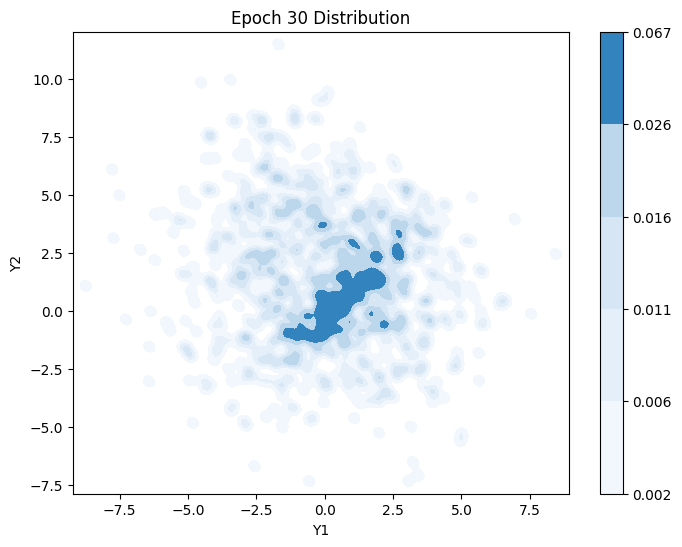

Epoch 30 - D Loss: 0.0164, G Loss: 0.7588
Epoch 31 - D Loss: 0.0253, G Loss: 0.8140
Mean L1 Loss per dimension: tensor([2.0838, 2.1329])
Mean L2 Loss per dimension: tensor([7.1470, 7.1715])
Epoch 32, Iter 1250, D Loss: 0.0255, G Loss: 0.6607, L1: 2.1083, L2: 7.1593
Epoch 32 - D Loss: 0.0250, G Loss: 0.8264
Mean L1 Loss per dimension: tensor([2.0282, 2.1737])
Mean L2 Loss per dimension: tensor([6.4910, 7.3686])
Epoch 33, Iter 1300, D Loss: 0.0241, G Loss: 0.8404, L1: 2.1010, L2: 6.9298
Epoch 33 - D Loss: 0.0272, G Loss: 0.8073
Mean L1 Loss per dimension: tensor([2.0374, 2.0274])
Mean L2 Loss per dimension: tensor([6.5427, 6.8147])
Epoch 34, Iter 1350, D Loss: 0.0095, G Loss: 0.8257, L1: 2.0324, L2: 6.6787
Epoch 34 - D Loss: 0.0189, G Loss: 0.8385
Mean L1 Loss per dimension: tensor([2.0162, 2.0557])
Mean L2 Loss per dimension: tensor([6.4637, 6.9370])
Epoch 35, Iter 1400, D Loss: 0.0131, G Loss: 0.8575, L1: 2.0359, L2: 6.7003


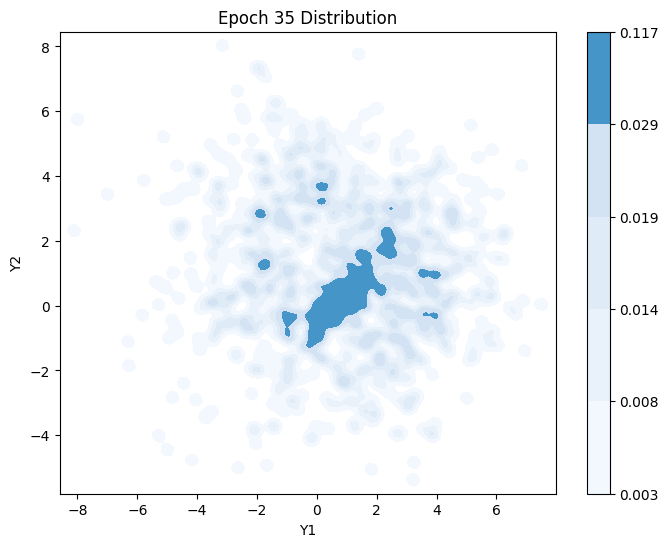

Epoch 35 - D Loss: 0.0181, G Loss: 0.8631
Epoch 36 - D Loss: 0.0162, G Loss: 0.8335
Mean L1 Loss per dimension: tensor([2.0380, 2.0461])
Mean L2 Loss per dimension: tensor([6.5700, 7.0387])
Epoch 37, Iter 1450, D Loss: 0.0267, G Loss: 0.8403, L1: 2.0421, L2: 6.8044
Epoch 37 - D Loss: 0.0166, G Loss: 0.9255
Mean L1 Loss per dimension: tensor([2.0658, 2.0299])
Mean L2 Loss per dimension: tensor([6.4942, 6.8557])
Epoch 38, Iter 1500, D Loss: 0.0297, G Loss: 0.8805, L1: 2.0479, L2: 6.6750
New best multivariate model with L2: 6.6750
Epoch 38 - D Loss: 0.0261, G Loss: 0.8852
Mean L1 Loss per dimension: tensor([2.1020, 2.0751])
Mean L2 Loss per dimension: tensor([6.6184, 6.8791])
Epoch 39, Iter 1550, D Loss: 0.0209, G Loss: 0.8281, L1: 2.0886, L2: 6.7487
Epoch 39 - D Loss: 0.0211, G Loss: 0.8834
Epoch 40 - D Loss: 0.0201, G Loss: 0.8429
Mean L1 Loss per dimension: tensor([2.0265, 2.0481])
Mean L2 Loss per dimension: tensor([6.4448, 6.8791])
Epoch 41, Iter 1600, D Loss: 0.0572, G Loss: 0.9404,

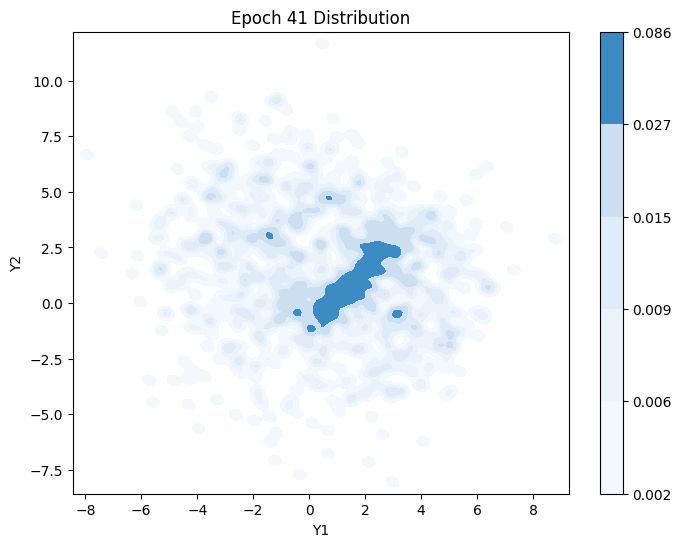

New best multivariate model with L2: 6.6620
Epoch 41 - D Loss: 0.0311, G Loss: 0.8427
Mean L1 Loss per dimension: tensor([2.0335, 2.0747])
Mean L2 Loss per dimension: tensor([6.5759, 6.9672])
Epoch 42, Iter 1650, D Loss: 0.0272, G Loss: 0.8361, L1: 2.0541, L2: 6.7716
Epoch 42 - D Loss: 0.0232, G Loss: 0.8434
Mean L1 Loss per dimension: tensor([2.0752, 2.0287])
Mean L2 Loss per dimension: tensor([6.4715, 6.8542])
Epoch 43, Iter 1700, D Loss: 0.0394, G Loss: 0.8621, L1: 2.0519, L2: 6.6628
Epoch 43 - D Loss: 0.0289, G Loss: 0.8032
Mean L1 Loss per dimension: tensor([2.0553, 2.0519])
Mean L2 Loss per dimension: tensor([6.4710, 6.8802])
Epoch 44, Iter 1750, D Loss: 0.0213, G Loss: 0.7856, L1: 2.0536, L2: 6.6756
Epoch 44 - D Loss: 0.0219, G Loss: 0.7930
Epoch 45 - D Loss: 0.0377, G Loss: 0.7497
Mean L1 Loss per dimension: tensor([2.0317, 2.0459])
Mean L2 Loss per dimension: tensor([6.5494, 6.8966])
Epoch 46, Iter 1800, D Loss: 0.0344, G Loss: 0.7902, L1: 2.0388, L2: 6.7230


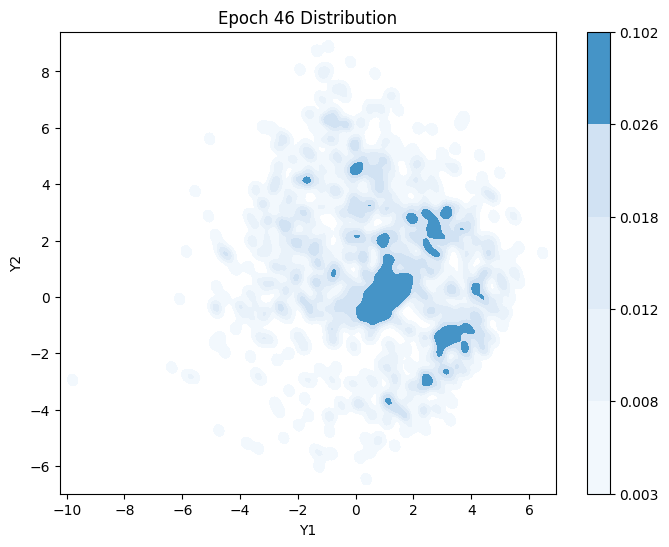

Epoch 46 - D Loss: 0.0303, G Loss: 0.6990
Mean L1 Loss per dimension: tensor([2.0987, 2.0723])
Mean L2 Loss per dimension: tensor([6.6444, 7.0388])
Epoch 47, Iter 1850, D Loss: 0.0233, G Loss: 0.6952, L1: 2.0855, L2: 6.8416
Epoch 47 - D Loss: 0.0313, G Loss: 0.6650
Mean L1 Loss per dimension: tensor([2.0369, 2.0413])
Mean L2 Loss per dimension: tensor([6.5115, 6.9906])
Epoch 48, Iter 1900, D Loss: 0.0537, G Loss: 0.6431, L1: 2.0391, L2: 6.7511
Epoch 48 - D Loss: 0.0507, G Loss: 0.6507
Mean L1 Loss per dimension: tensor([2.0540, 2.0292])
Mean L2 Loss per dimension: tensor([6.5100, 6.9093])
Epoch 49, Iter 1950, D Loss: 0.0445, G Loss: 0.5666, L1: 2.0416, L2: 6.7097
Epoch 49 - D Loss: 0.0445, G Loss: 0.5666
Epoch 50 - D Loss: 0.0381, G Loss: 0.5622
Mean L1 Loss per dimension: tensor([2.0531, 2.0288])
Mean L2 Loss per dimension: tensor([6.4613, 6.8399])
Epoch 51, Iter 2000, D Loss: 0.0434, G Loss: 0.5473, L1: 2.0409, L2: 6.6506


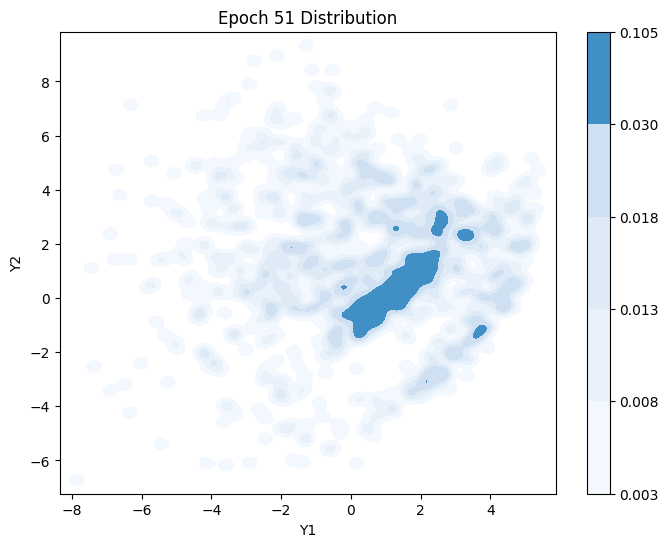

New best multivariate model with L2: 6.6506
Epoch 51 - D Loss: 0.0386, G Loss: 0.5207
Mean L1 Loss per dimension: tensor([2.0590, 2.0250])
Mean L2 Loss per dimension: tensor([6.4654, 6.9493])
Epoch 52, Iter 2050, D Loss: 0.0584, G Loss: 0.4962, L1: 2.0420, L2: 6.7074
Epoch 52 - D Loss: 0.0544, G Loss: 0.4914
Mean L1 Loss per dimension: tensor([2.0200, 2.0728])
Mean L2 Loss per dimension: tensor([6.4023, 6.8873])
Epoch 53, Iter 2100, D Loss: 0.0430, G Loss: 0.4682, L1: 2.0464, L2: 6.6448
New best multivariate model with L2: 6.6448
Epoch 53 - D Loss: 0.0441, G Loss: 0.4597
Epoch 54 - D Loss: 0.0459, G Loss: 0.4147
Mean L1 Loss per dimension: tensor([2.0291, 2.0413])
Mean L2 Loss per dimension: tensor([6.4483, 6.9919])
Epoch 55, Iter 2150, D Loss: 0.0267, G Loss: 0.4968, L1: 2.0352, L2: 6.7201
Epoch 55 - D Loss: 0.0449, G Loss: 0.4234
Mean L1 Loss per dimension: tensor([2.0097, 2.0278])
Mean L2 Loss per dimension: tensor([6.4043, 6.9395])
Epoch 56, Iter 2200, D Loss: 0.0394, G Loss: 0.366

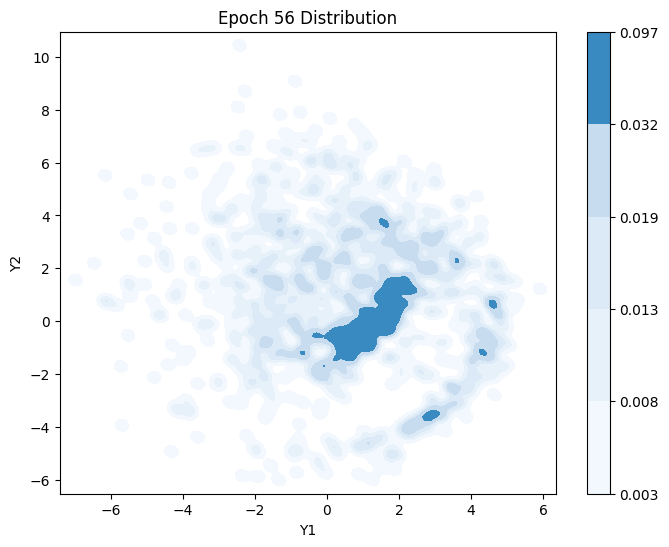

Epoch 56 - D Loss: 0.0354, G Loss: 0.3973
Mean L1 Loss per dimension: tensor([2.0297, 2.0631])
Mean L2 Loss per dimension: tensor([6.3566, 6.8614])
Epoch 57, Iter 2250, D Loss: 0.0601, G Loss: 0.4260, L1: 2.0464, L2: 6.6090
New best multivariate model with L2: 6.6090
Epoch 57 - D Loss: 0.0488, G Loss: 0.4287
Mean L1 Loss per dimension: tensor([2.0478, 2.0455])
Mean L2 Loss per dimension: tensor([6.4387, 6.8929])
Epoch 58, Iter 2300, D Loss: 0.0352, G Loss: 0.3756, L1: 2.0466, L2: 6.6658
Epoch 58 - D Loss: 0.0354, G Loss: 0.3720
Epoch 59 - D Loss: 0.0369, G Loss: 0.3492
Mean L1 Loss per dimension: tensor([2.0272, 2.0771])
Mean L2 Loss per dimension: tensor([6.4724, 6.9765])
Epoch 60, Iter 2350, D Loss: 0.0676, G Loss: 0.3668, L1: 2.0521, L2: 6.7244
Epoch 60 - D Loss: 0.0446, G Loss: 0.3234
Mean L1 Loss per dimension: tensor([2.0519, 2.0246])
Mean L2 Loss per dimension: tensor([6.4934, 6.8424])
Epoch 61, Iter 2400, D Loss: 0.0335, G Loss: 0.3377, L1: 2.0382, L2: 6.6679


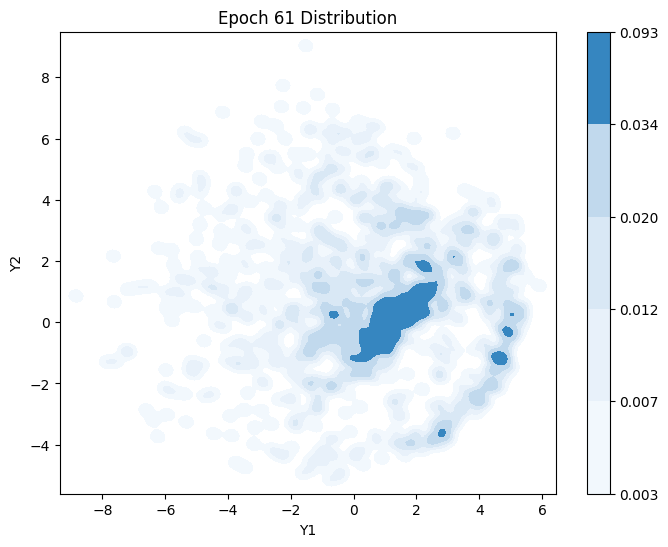

Epoch 61 - D Loss: 0.0321, G Loss: 0.3325
Mean L1 Loss per dimension: tensor([2.0383, 2.0495])
Mean L2 Loss per dimension: tensor([6.4915, 6.9317])
Epoch 62, Iter 2450, D Loss: 0.0487, G Loss: 0.3227, L1: 2.0439, L2: 6.7116
Epoch 62 - D Loss: 0.0478, G Loss: 0.3495
Epoch 63 - D Loss: 0.0364, G Loss: 0.3216
Mean L1 Loss per dimension: tensor([2.0430, 2.0233])
Mean L2 Loss per dimension: tensor([6.5101, 6.9128])
Epoch 64, Iter 2500, D Loss: 0.0371, G Loss: 0.2899, L1: 2.0332, L2: 6.7114
Epoch 64 - D Loss: 0.0353, G Loss: 0.2999
Mean L1 Loss per dimension: tensor([2.0503, 2.0294])
Mean L2 Loss per dimension: tensor([6.4838, 6.8102])
Epoch 65, Iter 2550, D Loss: 0.0619, G Loss: 0.3086, L1: 2.0399, L2: 6.6470
Epoch 65 - D Loss: 0.0478, G Loss: 0.3340
Mean L1 Loss per dimension: tensor([2.0652, 2.0256])
Mean L2 Loss per dimension: tensor([6.5399, 6.8523])
Epoch 66, Iter 2600, D Loss: 0.0390, G Loss: 0.3297, L1: 2.0454, L2: 6.6961


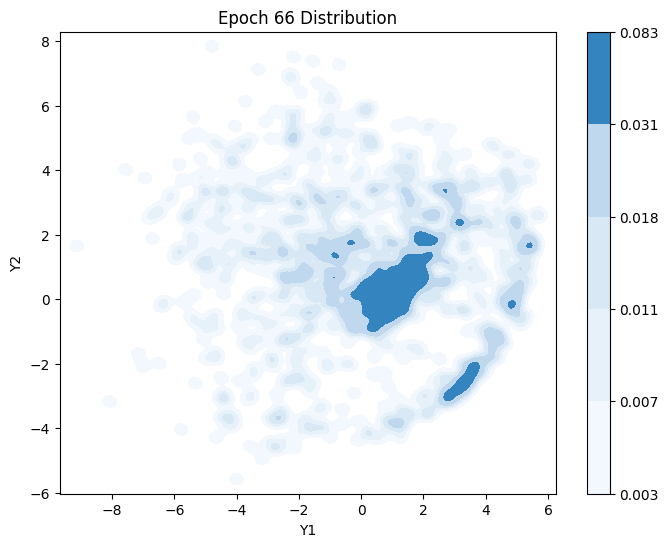

Epoch 66 - D Loss: 0.0377, G Loss: 0.2861
Mean L1 Loss per dimension: tensor([2.0413, 2.0470])
Mean L2 Loss per dimension: tensor([6.4878, 6.8067])
Epoch 67, Iter 2650, D Loss: 0.0377, G Loss: 0.2495, L1: 2.0441, L2: 6.6473
Epoch 67 - D Loss: 0.0362, G Loss: 0.2523
Epoch 68 - D Loss: 0.0334, G Loss: 0.2377
Mean L1 Loss per dimension: tensor([2.0176, 2.0351])
Mean L2 Loss per dimension: tensor([6.3493, 6.8146])
Epoch 69, Iter 2700, D Loss: 0.0672, G Loss: 0.2682, L1: 2.0264, L2: 6.5820
New best multivariate model with L2: 6.5820
Epoch 69 - D Loss: 0.0398, G Loss: 0.2241
Mean L1 Loss per dimension: tensor([2.0325, 2.0515])
Mean L2 Loss per dimension: tensor([6.4862, 6.9718])
Epoch 70, Iter 2750, D Loss: 0.0255, G Loss: 0.2616, L1: 2.0420, L2: 6.7290
Epoch 70 - D Loss: 0.0350, G Loss: 0.2391
Mean L1 Loss per dimension: tensor([2.0418, 2.0293])
Mean L2 Loss per dimension: tensor([6.5576, 6.7865])
Epoch 71, Iter 2800, D Loss: 0.0301, G Loss: 0.1591, L1: 2.0355, L2: 6.6720


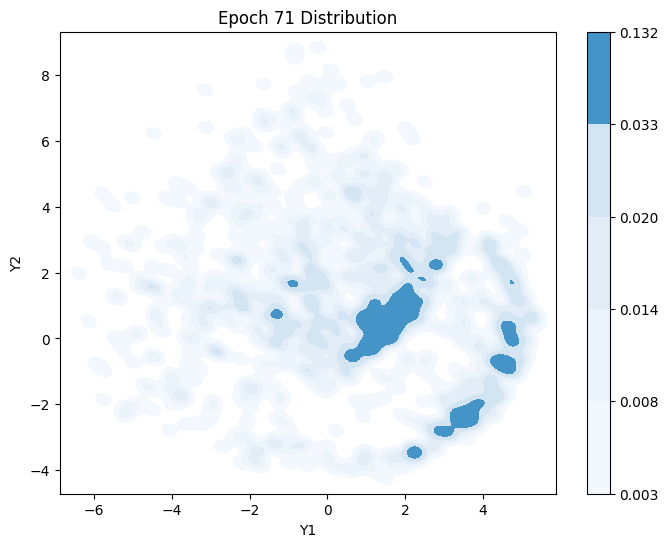

Epoch 71 - D Loss: 0.0341, G Loss: 0.1748
Epoch 72 - D Loss: 0.0296, G Loss: 0.1788
Mean L1 Loss per dimension: tensor([2.0348, 2.0225])
Mean L2 Loss per dimension: tensor([6.3833, 6.9132])
Epoch 73, Iter 2850, D Loss: 0.0050, G Loss: 0.3314, L1: 2.0286, L2: 6.6483
Epoch 73 - D Loss: 0.0294, G Loss: 0.1811
Mean L1 Loss per dimension: tensor([2.0281, 2.0391])
Mean L2 Loss per dimension: tensor([6.4407, 6.9390])
Epoch 74, Iter 2900, D Loss: 0.0337, G Loss: 0.2227, L1: 2.0336, L2: 6.6899
Epoch 74 - D Loss: 0.0341, G Loss: 0.1899
Mean L1 Loss per dimension: tensor([2.0397, 2.1346])
Mean L2 Loss per dimension: tensor([6.5793, 7.1619])
Epoch 75, Iter 2950, D Loss: 0.0300, G Loss: 0.1408, L1: 2.0872, L2: 6.8706
Epoch 75 - D Loss: 0.0325, G Loss: 0.1675
Mean L1 Loss per dimension: tensor([2.0705, 2.0374])
Mean L2 Loss per dimension: tensor([6.5097, 6.8581])
Epoch 76, Iter 3000, D Loss: 0.0326, G Loss: 0.1755, L1: 2.0540, L2: 6.6839


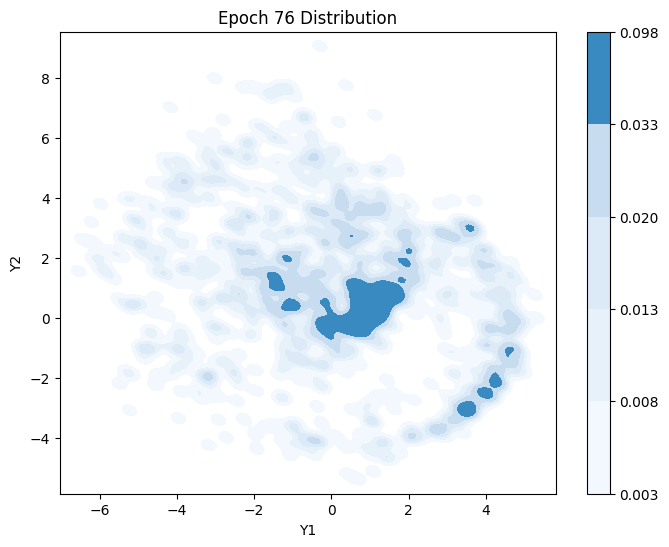

Epoch 76 - D Loss: 0.0310, G Loss: 0.1706
Epoch 77 - D Loss: 0.0408, G Loss: 0.1767
Mean L1 Loss per dimension: tensor([2.0321, 2.0276])
Mean L2 Loss per dimension: tensor([6.5433, 6.8937])
Epoch 78, Iter 3050, D Loss: 0.0289, G Loss: 0.1117, L1: 2.0298, L2: 6.7185
Epoch 78 - D Loss: 0.0358, G Loss: 0.1431
Mean L1 Loss per dimension: tensor([2.0300, 2.0323])
Mean L2 Loss per dimension: tensor([6.5394, 6.9002])
Epoch 79, Iter 3100, D Loss: 0.0393, G Loss: 0.1551, L1: 2.0311, L2: 6.7198
Epoch 79 - D Loss: 0.0387, G Loss: 0.1450
Mean L1 Loss per dimension: tensor([2.0330, 2.0556])
Mean L2 Loss per dimension: tensor([6.4434, 6.8834])
Epoch 80, Iter 3150, D Loss: 0.0381, G Loss: 0.1523, L1: 2.0443, L2: 6.6634
Epoch 80 - D Loss: 0.0397, G Loss: 0.1340
Epoch 81 - D Loss: 0.0494, G Loss: 0.1235
Mean L1 Loss per dimension: tensor([2.0327, 2.0681])
Mean L2 Loss per dimension: tensor([6.4832, 6.9666])
Epoch 82, Iter 3200, D Loss: 0.0435, G Loss: 0.1181, L1: 2.0504, L2: 6.7249


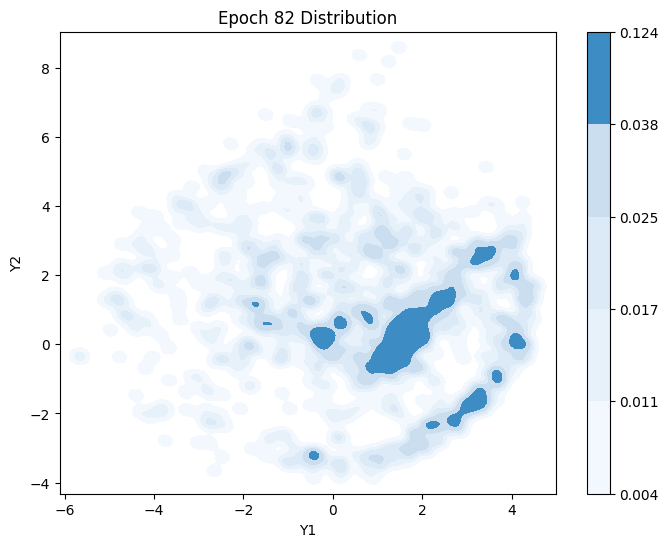

Epoch 82 - D Loss: 0.0355, G Loss: 0.1510
Mean L1 Loss per dimension: tensor([2.0289, 2.0517])
Mean L2 Loss per dimension: tensor([6.4313, 6.8792])
Epoch 83, Iter 3250, D Loss: 0.0433, G Loss: 0.2146, L1: 2.0403, L2: 6.6552
Epoch 83 - D Loss: 0.0427, G Loss: 0.1526
Mean L1 Loss per dimension: tensor([2.0468, 2.0400])
Mean L2 Loss per dimension: tensor([6.4553, 6.9084])
Epoch 84, Iter 3300, D Loss: 0.0505, G Loss: 0.1128, L1: 2.0434, L2: 6.6818
Epoch 84 - D Loss: 0.0505, G Loss: 0.1410
Mean L1 Loss per dimension: tensor([2.0479, 2.0222])
Mean L2 Loss per dimension: tensor([6.4995, 6.8839])
Epoch 85, Iter 3350, D Loss: 0.0412, G Loss: 0.1683, L1: 2.0351, L2: 6.6917
Epoch 85 - D Loss: 0.0433, G Loss: 0.1748
Epoch 86 - D Loss: 0.0504, G Loss: 0.1220
Mean L1 Loss per dimension: tensor([2.1113, 2.0215])
Mean L2 Loss per dimension: tensor([6.6784, 6.8885])
Epoch 87, Iter 3400, D Loss: 0.0417, G Loss: 0.1178, L1: 2.0664, L2: 6.7835


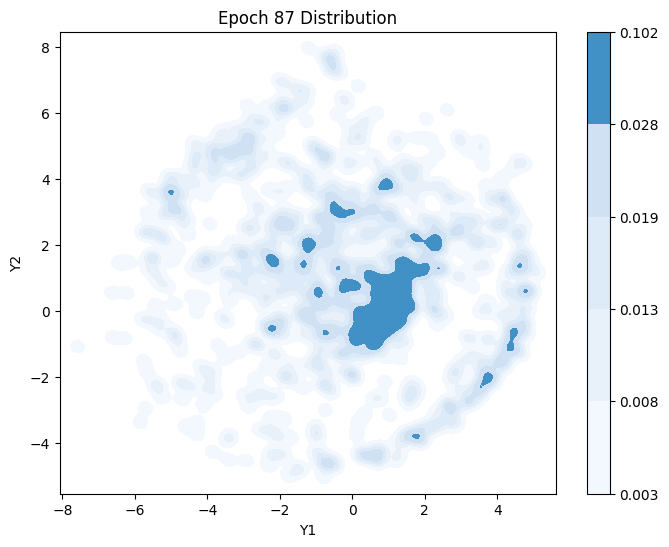

Epoch 87 - D Loss: 0.0441, G Loss: 0.1305
Mean L1 Loss per dimension: tensor([2.0376, 2.0338])
Mean L2 Loss per dimension: tensor([6.4395, 6.8916])
Epoch 88, Iter 3450, D Loss: 0.0487, G Loss: 0.1167, L1: 2.0357, L2: 6.6656
Epoch 88 - D Loss: 0.0453, G Loss: 0.1380
Mean L1 Loss per dimension: tensor([2.0472, 2.0386])
Mean L2 Loss per dimension: tensor([6.4874, 6.9097])
Epoch 89, Iter 3500, D Loss: 0.0436, G Loss: 0.1096, L1: 2.0429, L2: 6.6985
Epoch 89 - D Loss: 0.0443, G Loss: 0.1426
Epoch 90 - D Loss: 0.0522, G Loss: 0.1563
Mean L1 Loss per dimension: tensor([2.0191, 2.0138])
Mean L2 Loss per dimension: tensor([6.4707, 6.8457])
Epoch 91, Iter 3550, D Loss: 0.0561, G Loss: 0.3070, L1: 2.0165, L2: 6.6582
Epoch 91 - D Loss: 0.0521, G Loss: 0.1609
Mean L1 Loss per dimension: tensor([2.0360, 2.0418])
Mean L2 Loss per dimension: tensor([6.4667, 6.8985])
Epoch 92, Iter 3600, D Loss: 0.0556, G Loss: 0.1846, L1: 2.0389, L2: 6.6826


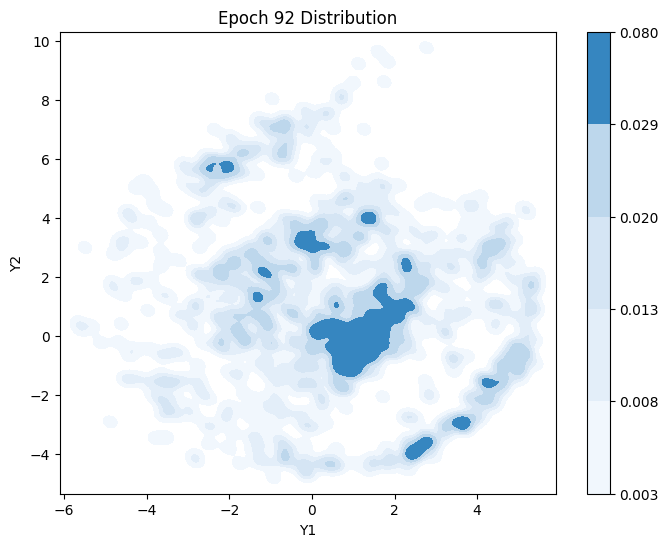

Epoch 92 - D Loss: 0.0514, G Loss: 0.1590
Mean L1 Loss per dimension: tensor([2.0446, 2.0516])
Mean L2 Loss per dimension: tensor([6.7612, 6.8863])
Epoch 93, Iter 3650, D Loss: 0.0509, G Loss: 0.1690, L1: 2.0481, L2: 6.8237
Epoch 93 - D Loss: 0.0532, G Loss: 0.1434
Mean L1 Loss per dimension: tensor([2.0505, 2.0389])
Mean L2 Loss per dimension: tensor([6.4111, 6.8637])
Epoch 94, Iter 3700, D Loss: 0.0556, G Loss: 0.1458, L1: 2.0447, L2: 6.6374
Epoch 94 - D Loss: 0.0556, G Loss: 0.1566
Epoch 95 - D Loss: 0.0496, G Loss: 0.1517
Mean L1 Loss per dimension: tensor([2.0278, 2.0395])
Mean L2 Loss per dimension: tensor([6.3716, 6.8594])
Epoch 96, Iter 3750, D Loss: 0.0616, G Loss: 0.1538, L1: 2.0336, L2: 6.6155
Epoch 96 - D Loss: 0.0558, G Loss: 0.1858
Mean L1 Loss per dimension: tensor([2.0470, 2.0444])
Mean L2 Loss per dimension: tensor([6.4516, 6.8612])
Epoch 97, Iter 3800, D Loss: 0.0526, G Loss: 0.1077, L1: 2.0457, L2: 6.6564


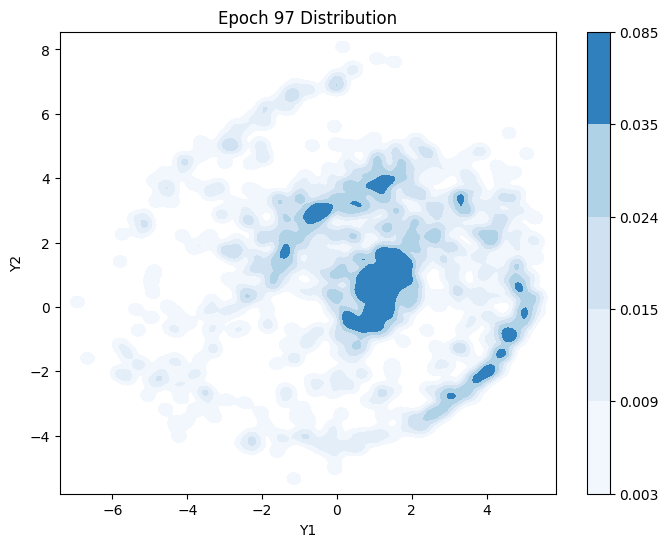

Epoch 97 - D Loss: 0.0529, G Loss: 0.1627
Mean L1 Loss per dimension: tensor([2.0382, 2.0337])
Mean L2 Loss per dimension: tensor([6.4829, 6.8872])
Epoch 98, Iter 3850, D Loss: 0.0540, G Loss: 0.1529, L1: 2.0360, L2: 6.6850
Epoch 98 - D Loss: 0.0551, G Loss: 0.1538
Mean L1 Loss per dimension: tensor([2.0379, 2.0671])
Mean L2 Loss per dimension: tensor([6.4479, 6.9668])
Epoch 99, Iter 3900, D Loss: 0.0505, G Loss: 0.1756, L1: 2.0525, L2: 6.7073
Epoch 99 - D Loss: 0.0505, G Loss: 0.1756
Epoch 100 - D Loss: 0.0462, G Loss: 0.1543
Mean L1 Loss per dimension: tensor([2.0415, 2.0358])
Mean L2 Loss per dimension: tensor([6.7166, 6.8915])
Epoch 101, Iter 3950, D Loss: 0.0557, G Loss: 0.1679, L1: 2.0387, L2: 6.8040
Epoch 101 - D Loss: 0.0474, G Loss: 0.1613
Mean L1 Loss per dimension: tensor([2.0662, 2.0619])
Mean L2 Loss per dimension: tensor([6.4597, 6.9463])
Epoch 102, Iter 4000, D Loss: 0.0525, G Loss: 0.1599, L1: 2.0640, L2: 6.7030


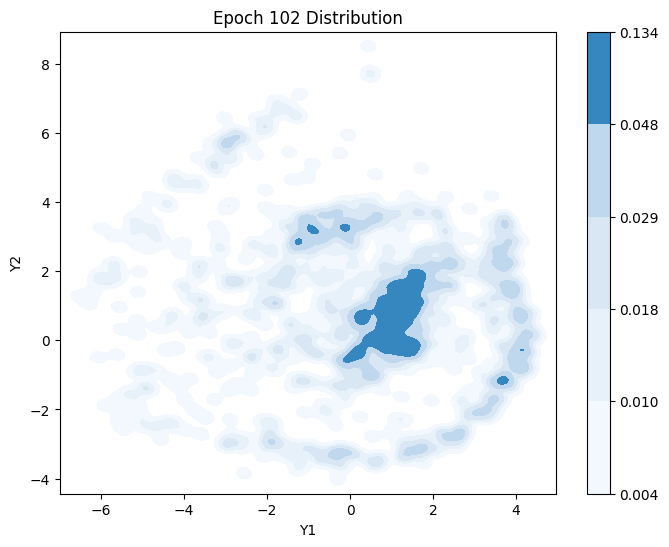

Epoch 102 - D Loss: 0.0614, G Loss: 0.1840
Mean L1 Loss per dimension: tensor([2.0318, 2.0349])
Mean L2 Loss per dimension: tensor([6.5176, 6.9271])
Epoch 103, Iter 4050, D Loss: 0.0516, G Loss: 0.1727, L1: 2.0334, L2: 6.7224
Epoch 103 - D Loss: 0.0503, G Loss: 0.1739
Epoch 104 - D Loss: 0.0577, G Loss: 0.1982
Mean L1 Loss per dimension: tensor([2.0360, 2.0336])
Mean L2 Loss per dimension: tensor([6.4093, 6.9578])
Epoch 105, Iter 4100, D Loss: 0.0608, G Loss: 0.2225, L1: 2.0348, L2: 6.6836
Epoch 105 - D Loss: 0.0601, G Loss: 0.1974
Mean L1 Loss per dimension: tensor([2.0433, 2.0417])
Mean L2 Loss per dimension: tensor([6.5703, 6.8475])
Epoch 106, Iter 4150, D Loss: 0.0618, G Loss: 0.1300, L1: 2.0425, L2: 6.7089
Epoch 106 - D Loss: 0.0602, G Loss: 0.1794
Mean L1 Loss per dimension: tensor([2.0157, 2.0214])
Mean L2 Loss per dimension: tensor([6.4021, 6.8564])
Epoch 107, Iter 4200, D Loss: 0.0534, G Loss: 0.1856, L1: 2.0186, L2: 6.6293


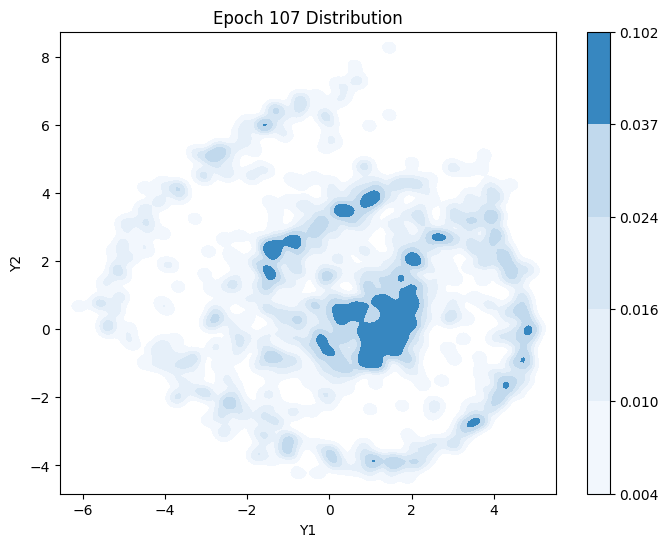

Epoch 107 - D Loss: 0.0552, G Loss: 0.1699
Mean L1 Loss per dimension: tensor([2.0442, 2.0570])
Mean L2 Loss per dimension: tensor([6.4709, 6.8720])
Epoch 108, Iter 4250, D Loss: 0.0479, G Loss: 0.1929, L1: 2.0506, L2: 6.6715
Epoch 108 - D Loss: 0.0469, G Loss: 0.1940
Epoch 109 - D Loss: 0.0692, G Loss: 0.2078
Mean L1 Loss per dimension: tensor([2.0555, 2.1206])
Mean L2 Loss per dimension: tensor([6.8057, 7.0888])
Epoch 110, Iter 4300, D Loss: 0.0620, G Loss: 0.2506, L1: 2.0880, L2: 6.9472
Epoch 110 - D Loss: 0.0580, G Loss: 0.1828
Mean L1 Loss per dimension: tensor([2.0559, 2.0193])
Mean L2 Loss per dimension: tensor([6.5037, 6.8985])
Epoch 111, Iter 4350, D Loss: 0.0501, G Loss: 0.1685, L1: 2.0376, L2: 6.7011
Epoch 111 - D Loss: 0.0541, G Loss: 0.1702
Mean L1 Loss per dimension: tensor([2.0231, 2.0728])
Mean L2 Loss per dimension: tensor([6.4993, 6.9538])
Epoch 112, Iter 4400, D Loss: 0.0641, G Loss: 0.1533, L1: 2.0480, L2: 6.7265


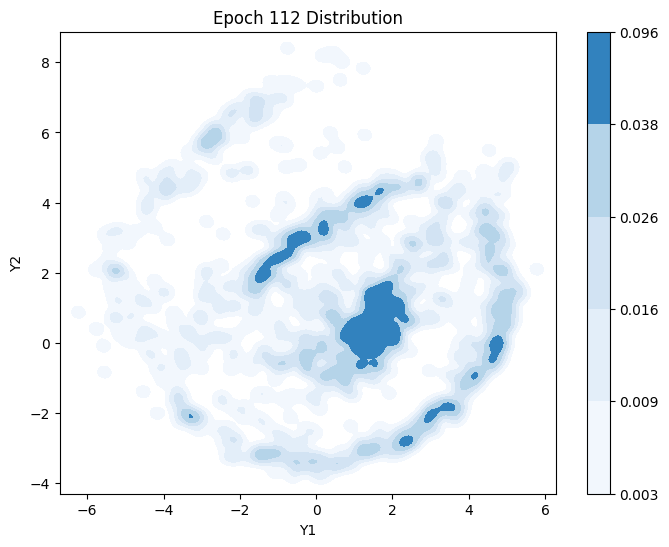

Epoch 112 - D Loss: 0.0606, G Loss: 0.1716
Epoch 113 - D Loss: 0.0714, G Loss: 0.1859
Mean L1 Loss per dimension: tensor([2.0422, 2.0404])
Mean L2 Loss per dimension: tensor([6.4584, 6.8736])
Epoch 114, Iter 4450, D Loss: 0.0630, G Loss: 0.3153, L1: 2.0413, L2: 6.6660
Epoch 114 - D Loss: 0.0788, G Loss: 0.1880
Mean L1 Loss per dimension: tensor([2.0741, 2.0816])
Mean L2 Loss per dimension: tensor([6.5031, 6.9135])
Epoch 115, Iter 4500, D Loss: 0.0717, G Loss: 0.1223, L1: 2.0779, L2: 6.7083
Epoch 115 - D Loss: 0.0671, G Loss: 0.1583
Mean L1 Loss per dimension: tensor([2.0897, 2.0507])
Mean L2 Loss per dimension: tensor([6.6123, 6.8979])
Epoch 116, Iter 4550, D Loss: 0.0703, G Loss: 0.1442, L1: 2.0702, L2: 6.7551
Epoch 116 - D Loss: 0.0631, G Loss: 0.1369
Mean L1 Loss per dimension: tensor([2.0316, 2.0365])
Mean L2 Loss per dimension: tensor([6.4090, 6.8752])
Epoch 117, Iter 4600, D Loss: 0.0612, G Loss: 0.1483, L1: 2.0341, L2: 6.6421


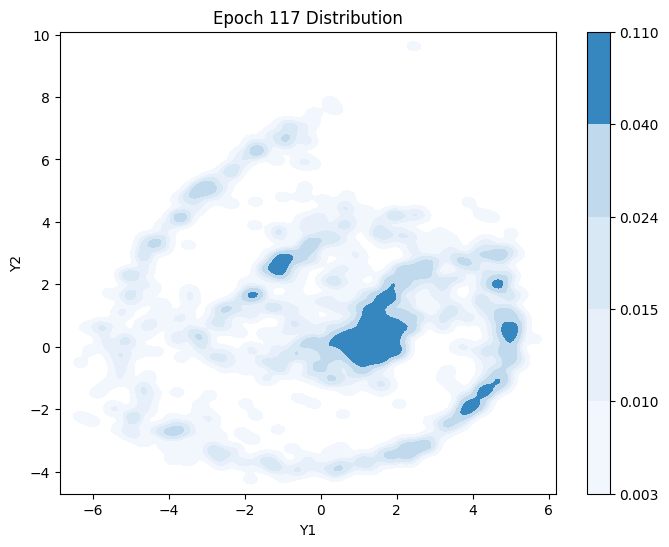

Epoch 117 - D Loss: 0.0613, G Loss: 0.1524
Epoch 118 - D Loss: 0.0561, G Loss: 0.1487
Mean L1 Loss per dimension: tensor([2.0301, 2.0493])
Mean L2 Loss per dimension: tensor([6.5776, 6.9086])
Epoch 119, Iter 4650, D Loss: 0.0769, G Loss: 0.1908, L1: 2.0397, L2: 6.7431
Epoch 119 - D Loss: 0.0684, G Loss: 0.1899
Mean L1 Loss per dimension: tensor([2.0318, 2.1215])
Mean L2 Loss per dimension: tensor([6.5841, 7.1084])
Epoch 120, Iter 4700, D Loss: 0.0562, G Loss: 0.1473, L1: 2.0766, L2: 6.8463
Epoch 120 - D Loss: 0.0571, G Loss: 0.1465
Mean L1 Loss per dimension: tensor([2.0318, 2.0825])
Mean L2 Loss per dimension: tensor([6.4714, 6.9660])
Epoch 121, Iter 4750, D Loss: 0.0629, G Loss: 0.1470, L1: 2.0571, L2: 6.7187
Epoch 121 - D Loss: 0.0612, G Loss: 0.1464
Epoch 122 - D Loss: 0.0535, G Loss: 0.1489
Mean L1 Loss per dimension: tensor([2.0456, 2.0282])
Mean L2 Loss per dimension: tensor([6.7737, 6.8920])
Epoch 123, Iter 4800, D Loss: 0.0665, G Loss: 0.0634, L1: 2.0369, L2: 6.8329


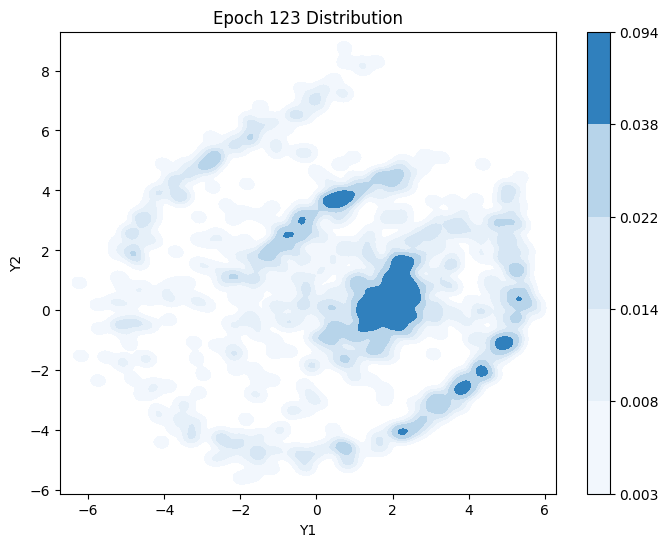

Epoch 123 - D Loss: 0.0463, G Loss: 0.1708
Mean L1 Loss per dimension: tensor([2.0235, 2.0457])
Mean L2 Loss per dimension: tensor([6.3768, 6.8444])
Epoch 124, Iter 4850, D Loss: 0.0540, G Loss: 0.1284, L1: 2.0346, L2: 6.6106
Epoch 124 - D Loss: 0.0520, G Loss: 0.1628
Mean L1 Loss per dimension: tensor([2.0611, 2.0463])
Mean L2 Loss per dimension: tensor([6.4899, 6.9902])
Epoch 125, Iter 4900, D Loss: 0.0586, G Loss: 0.1594, L1: 2.0537, L2: 6.7400
Epoch 125 - D Loss: 0.0547, G Loss: 0.1635
Mean L1 Loss per dimension: tensor([2.0434, 2.0465])
Mean L2 Loss per dimension: tensor([6.4670, 6.9449])
Epoch 126, Iter 4950, D Loss: 0.0446, G Loss: 0.1685, L1: 2.0449, L2: 6.7060
Epoch 126 - D Loss: 0.0444, G Loss: 0.1700
Epoch 127 - D Loss: 0.0464, G Loss: 0.1712
Mean L1 Loss per dimension: tensor([2.0380, 2.0553])
Mean L2 Loss per dimension: tensor([6.5160, 6.9223])
Epoch 128, Iter 5000, D Loss: 0.0413, G Loss: 0.1722, L1: 2.0466, L2: 6.7192


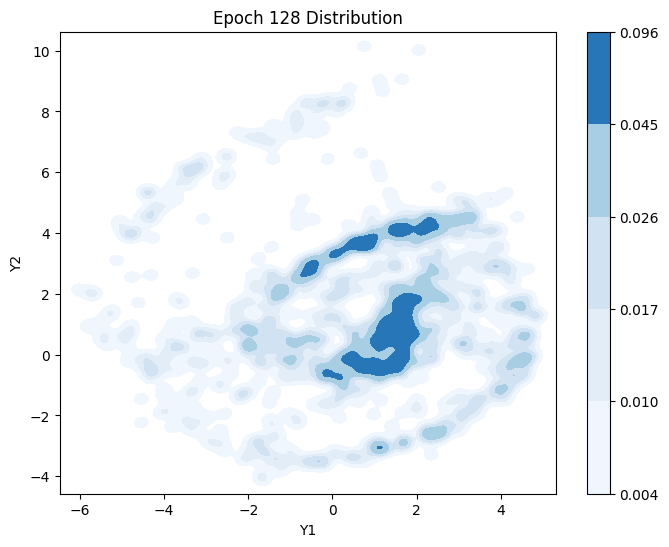

Epoch 128 - D Loss: 0.0447, G Loss: 0.1861
Mean L1 Loss per dimension: tensor([2.0459, 2.0350])
Mean L2 Loss per dimension: tensor([6.4929, 6.8239])
Epoch 129, Iter 5050, D Loss: 0.0399, G Loss: 0.1591, L1: 2.0404, L2: 6.6584
Epoch 129 - D Loss: 0.0429, G Loss: 0.1645
Mean L1 Loss per dimension: tensor([2.0364, 2.0458])
Mean L2 Loss per dimension: tensor([6.5573, 6.8592])
Epoch 130, Iter 5100, D Loss: 0.0432, G Loss: 0.1987, L1: 2.0411, L2: 6.7083
Epoch 130 - D Loss: 0.0442, G Loss: 0.1963
Epoch 131 - D Loss: 0.0389, G Loss: 0.1920
Mean L1 Loss per dimension: tensor([2.0320, 2.0466])
Mean L2 Loss per dimension: tensor([6.4858, 6.8495])
Epoch 132, Iter 5150, D Loss: 0.0335, G Loss: 0.2818, L1: 2.0393, L2: 6.6676
Epoch 132 - D Loss: 0.0432, G Loss: 0.2112
Mean L1 Loss per dimension: tensor([2.0532, 2.0604])
Mean L2 Loss per dimension: tensor([6.4615, 6.9061])
Epoch 133, Iter 5200, D Loss: 0.0451, G Loss: 0.1847, L1: 2.0568, L2: 6.6838


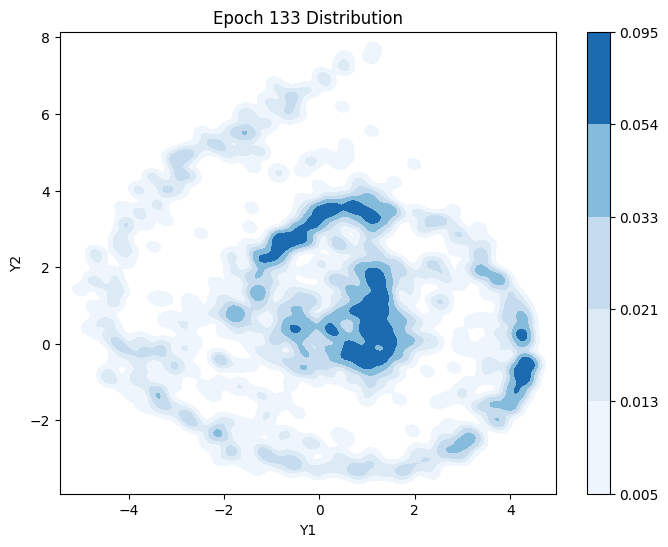

Epoch 133 - D Loss: 0.0566, G Loss: 0.2362
Mean L1 Loss per dimension: tensor([2.0376, 2.0305])
Mean L2 Loss per dimension: tensor([6.6639, 6.8930])
Epoch 134, Iter 5250, D Loss: 0.0582, G Loss: 0.2993, L1: 2.0341, L2: 6.7784
Epoch 134 - D Loss: 0.0544, G Loss: 0.2685
Mean L1 Loss per dimension: tensor([2.0730, 2.0410])
Mean L2 Loss per dimension: tensor([6.5066, 6.8570])
Epoch 135, Iter 5300, D Loss: 0.0444, G Loss: 0.2549, L1: 2.0570, L2: 6.6818
Epoch 135 - D Loss: 0.0455, G Loss: 0.2532
Epoch 136 - D Loss: 0.0487, G Loss: 0.2232
Mean L1 Loss per dimension: tensor([2.0416, 2.0558])
Mean L2 Loss per dimension: tensor([6.3731, 7.0374])
Epoch 137, Iter 5350, D Loss: 0.0481, G Loss: 0.2123, L1: 2.0487, L2: 6.7052
Epoch 137 - D Loss: 0.0470, G Loss: 0.2509
Mean L1 Loss per dimension: tensor([2.0278, 2.0554])
Mean L2 Loss per dimension: tensor([6.4280, 6.9233])
Epoch 138, Iter 5400, D Loss: 0.0523, G Loss: 0.2924, L1: 2.0416, L2: 6.6757


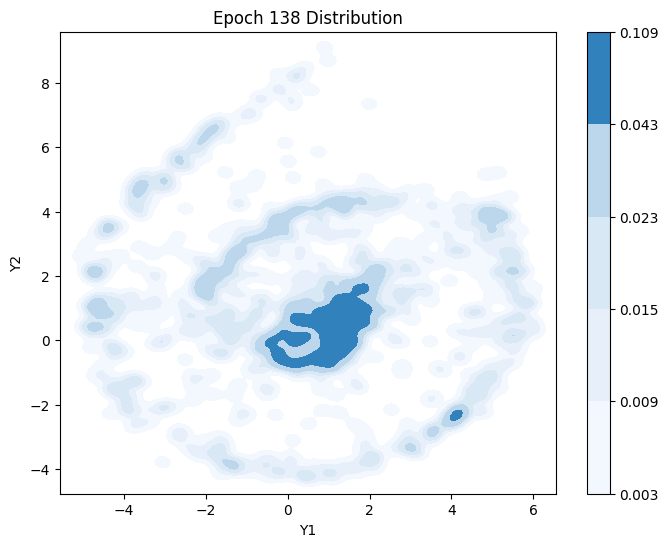

Epoch 138 - D Loss: 0.0520, G Loss: 0.2732
Mean L1 Loss per dimension: tensor([2.0370, 2.0542])
Mean L2 Loss per dimension: tensor([6.4376, 6.8786])
Epoch 139, Iter 5450, D Loss: 0.0556, G Loss: 0.2955, L1: 2.0456, L2: 6.6581
Epoch 139 - D Loss: 0.0627, G Loss: 0.2997
Epoch 140 - D Loss: 0.0521, G Loss: 0.2720
Mean L1 Loss per dimension: tensor([2.0285, 2.0572])
Mean L2 Loss per dimension: tensor([6.4500, 6.8865])
Epoch 141, Iter 5500, D Loss: 0.0560, G Loss: 0.2121, L1: 2.0428, L2: 6.6682
Epoch 141 - D Loss: 0.0458, G Loss: 0.2523
Mean L1 Loss per dimension: tensor([2.0625, 2.0683])
Mean L2 Loss per dimension: tensor([6.4222, 6.9290])
Epoch 142, Iter 5550, D Loss: 0.0462, G Loss: 0.2232, L1: 2.0654, L2: 6.6756
Epoch 142 - D Loss: 0.0447, G Loss: 0.2383
Mean L1 Loss per dimension: tensor([2.0440, 2.0434])
Mean L2 Loss per dimension: tensor([6.5484, 6.9124])
Epoch 143, Iter 5600, D Loss: 0.0565, G Loss: 0.2498, L1: 2.0437, L2: 6.7304


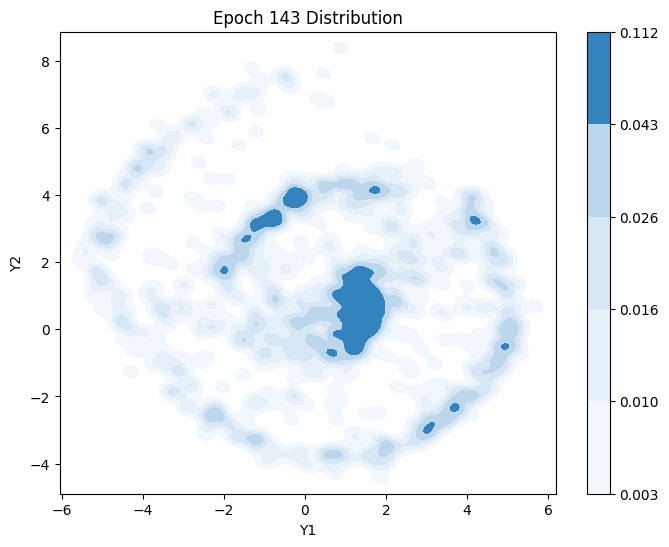

Epoch 143 - D Loss: 0.0576, G Loss: 0.2908
Mean L1 Loss per dimension: tensor([2.0747, 2.0207])
Mean L2 Loss per dimension: tensor([6.5250, 6.8122])
Epoch 144, Iter 5650, D Loss: 0.0585, G Loss: 0.3169, L1: 2.0477, L2: 6.6686
Epoch 144 - D Loss: 0.0579, G Loss: 0.3048
Epoch 145 - D Loss: 0.0480, G Loss: 0.2660
Mean L1 Loss per dimension: tensor([2.0457, 2.0327])
Mean L2 Loss per dimension: tensor([6.4178, 6.8675])
Epoch 146, Iter 5700, D Loss: 0.0429, G Loss: 0.2235, L1: 2.0392, L2: 6.6426
Epoch 146 - D Loss: 0.0416, G Loss: 0.2738
Mean L1 Loss per dimension: tensor([2.0240, 2.0469])
Mean L2 Loss per dimension: tensor([6.4791, 6.8680])
Epoch 147, Iter 5750, D Loss: 0.0440, G Loss: 0.2921, L1: 2.0355, L2: 6.6735
Epoch 147 - D Loss: 0.0466, G Loss: 0.2681
Mean L1 Loss per dimension: tensor([2.0429, 2.0445])
Mean L2 Loss per dimension: tensor([6.4616, 6.8759])
Epoch 148, Iter 5800, D Loss: 0.0451, G Loss: 0.2795, L1: 2.0437, L2: 6.6687


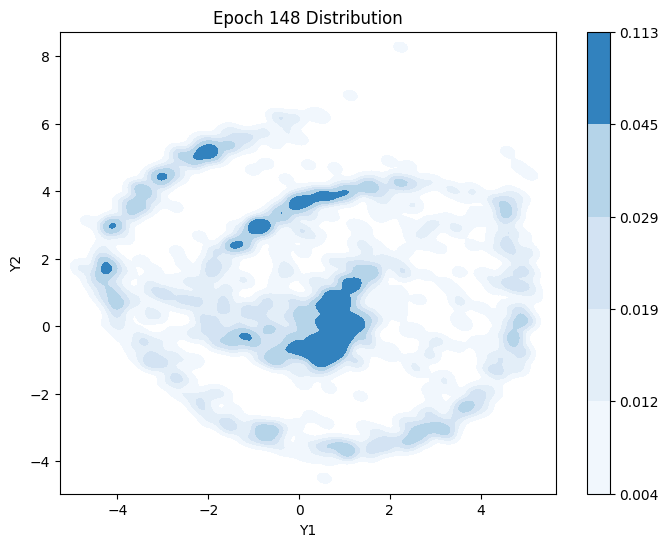

Epoch 148 - D Loss: 0.0463, G Loss: 0.2685
Mean L1 Loss per dimension: tensor([2.0308, 2.0297])
Mean L2 Loss per dimension: tensor([6.5263, 6.8593])
Epoch 149, Iter 5850, D Loss: 0.0521, G Loss: 0.2709, L1: 2.0303, L2: 6.6928
Epoch 149 - D Loss: 0.0521, G Loss: 0.2709
Epoch 150 - D Loss: 0.0492, G Loss: 0.2713
Mean L1 Loss per dimension: tensor([2.0393, 2.0383])
Mean L2 Loss per dimension: tensor([6.4015, 6.9059])
Epoch 151, Iter 5900, D Loss: 0.0488, G Loss: 0.2891, L1: 2.0388, L2: 6.6537
Epoch 151 - D Loss: 0.0484, G Loss: 0.2933
Mean L1 Loss per dimension: tensor([2.0436, 2.0262])
Mean L2 Loss per dimension: tensor([6.4828, 6.9249])
Epoch 152, Iter 5950, D Loss: 0.0615, G Loss: 0.2754, L1: 2.0349, L2: 6.7039
Epoch 152 - D Loss: 0.0571, G Loss: 0.2570
Mean L1 Loss per dimension: tensor([2.0355, 2.0454])
Mean L2 Loss per dimension: tensor([6.4097, 6.9444])
Epoch 153, Iter 6000, D Loss: 0.0439, G Loss: 0.2745, L1: 2.0404, L2: 6.6771


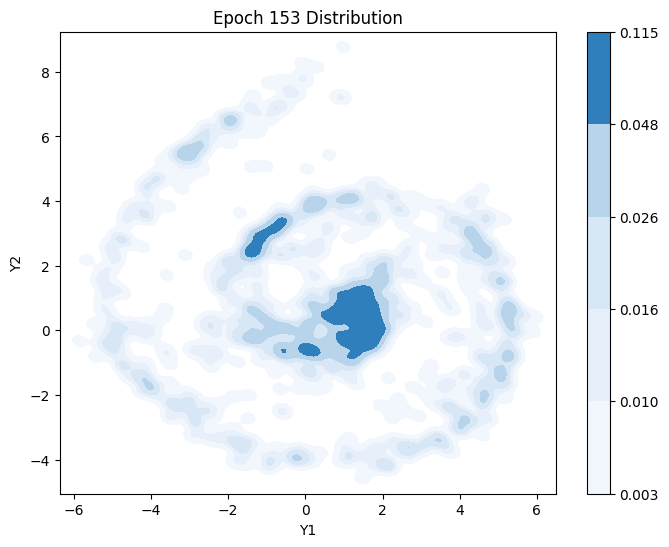

Epoch 153 - D Loss: 0.0442, G Loss: 0.2698
Epoch 154 - D Loss: 0.0464, G Loss: 0.2986
Mean L1 Loss per dimension: tensor([2.0246, 2.0311])
Mean L2 Loss per dimension: tensor([6.5108, 6.8851])
Epoch 155, Iter 6050, D Loss: 0.0501, G Loss: 0.2504, L1: 2.0278, L2: 6.6980
Epoch 155 - D Loss: 0.0487, G Loss: 0.2923
Mean L1 Loss per dimension: tensor([2.0537, 2.0703])
Mean L2 Loss per dimension: tensor([6.4381, 6.9636])
Epoch 156, Iter 6100, D Loss: 0.0330, G Loss: 0.2573, L1: 2.0620, L2: 6.7009
Epoch 156 - D Loss: 0.0374, G Loss: 0.2807
Mean L1 Loss per dimension: tensor([2.0488, 2.0446])
Mean L2 Loss per dimension: tensor([6.4433, 6.9292])
Epoch 157, Iter 6150, D Loss: 0.0425, G Loss: 0.2488, L1: 2.0467, L2: 6.6863
Epoch 157 - D Loss: 0.0433, G Loss: 0.2754
Mean L1 Loss per dimension: tensor([2.0479, 2.0382])
Mean L2 Loss per dimension: tensor([6.4876, 7.0355])
Epoch 158, Iter 6200, D Loss: 0.0420, G Loss: 0.2754, L1: 2.0430, L2: 6.7616


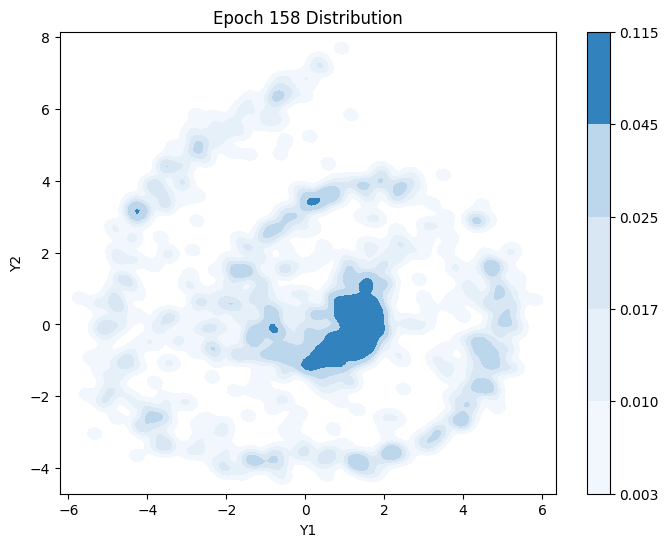

Epoch 158 - D Loss: 0.0420, G Loss: 0.2705
Epoch 159 - D Loss: 0.0403, G Loss: 0.2784
Mean L1 Loss per dimension: tensor([2.0264, 2.0465])
Mean L2 Loss per dimension: tensor([6.3801, 6.9826])
Epoch 160, Iter 6250, D Loss: 0.0446, G Loss: 0.2369, L1: 2.0365, L2: 6.6813
Epoch 160 - D Loss: 0.0424, G Loss: 0.2829
Mean L1 Loss per dimension: tensor([2.0602, 2.1422])
Mean L2 Loss per dimension: tensor([6.5347, 7.1970])
Epoch 161, Iter 6300, D Loss: 0.0569, G Loss: 0.3385, L1: 2.1012, L2: 6.8658
Epoch 161 - D Loss: 0.0628, G Loss: 0.3322
Mean L1 Loss per dimension: tensor([2.0772, 2.0886])
Mean L2 Loss per dimension: tensor([6.5285, 6.9915])
Epoch 162, Iter 6350, D Loss: 0.0509, G Loss: 0.3398, L1: 2.0829, L2: 6.7600
Epoch 162 - D Loss: 0.0521, G Loss: 0.3343
Epoch 163 - D Loss: 0.0462, G Loss: 0.2925
Mean L1 Loss per dimension: tensor([2.0185, 2.0495])
Mean L2 Loss per dimension: tensor([6.5122, 6.9042])
Epoch 164, Iter 6400, D Loss: 0.0361, G Loss: 0.2618, L1: 2.0340, L2: 6.7082


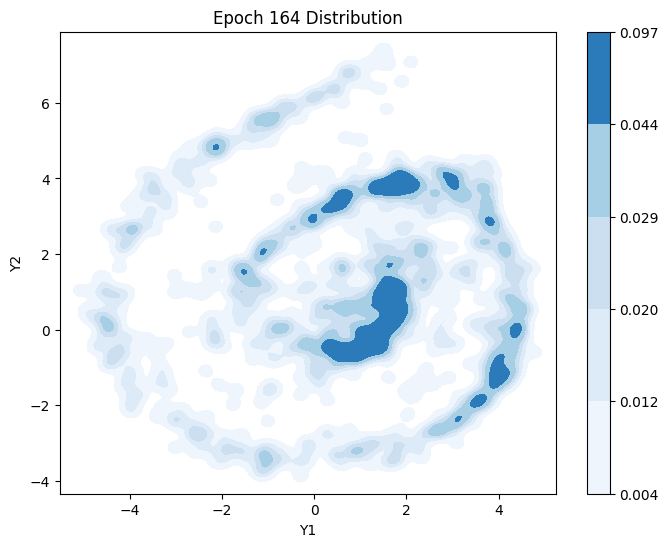

Epoch 164 - D Loss: 0.0429, G Loss: 0.3285
Mean L1 Loss per dimension: tensor([2.0397, 2.0369])
Mean L2 Loss per dimension: tensor([6.4206, 6.8892])
Epoch 165, Iter 6450, D Loss: 0.0536, G Loss: 0.2844, L1: 2.0383, L2: 6.6549
Epoch 165 - D Loss: 0.0524, G Loss: 0.3037
Mean L1 Loss per dimension: tensor([2.0415, 2.0558])
Mean L2 Loss per dimension: tensor([6.4591, 6.9387])
Epoch 166, Iter 6500, D Loss: 0.0486, G Loss: 0.2841, L1: 2.0487, L2: 6.6989
Epoch 166 - D Loss: 0.0471, G Loss: 0.2924
Mean L1 Loss per dimension: tensor([2.0494, 2.0325])
Mean L2 Loss per dimension: tensor([6.4627, 6.8722])
Epoch 167, Iter 6550, D Loss: 0.0434, G Loss: 0.2831, L1: 2.0410, L2: 6.6675
Epoch 167 - D Loss: 0.0441, G Loss: 0.2871
Epoch 168 - D Loss: 0.0470, G Loss: 0.2869
Mean L1 Loss per dimension: tensor([2.0375, 2.0414])
Mean L2 Loss per dimension: tensor([6.6899, 6.8775])
Epoch 169, Iter 6600, D Loss: 0.0522, G Loss: 0.3242, L1: 2.0394, L2: 6.7837


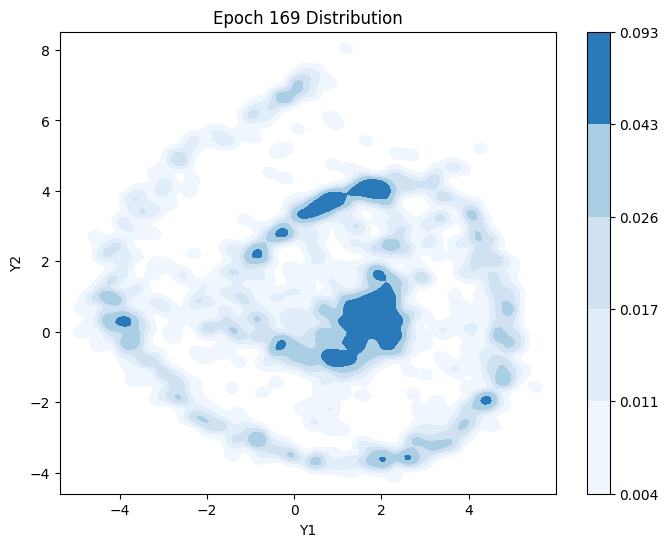

Epoch 169 - D Loss: 0.0536, G Loss: 0.2974
Mean L1 Loss per dimension: tensor([2.0247, 2.0837])
Mean L2 Loss per dimension: tensor([6.4142, 7.0145])
Epoch 170, Iter 6650, D Loss: 0.0392, G Loss: 0.2829, L1: 2.0542, L2: 6.7143
Epoch 170 - D Loss: 0.0468, G Loss: 0.2728
Mean L1 Loss per dimension: tensor([2.0275, 2.0767])
Mean L2 Loss per dimension: tensor([6.5508, 6.9174])
Epoch 171, Iter 6700, D Loss: 0.0474, G Loss: 0.2919, L1: 2.0521, L2: 6.7341
Epoch 171 - D Loss: 0.0468, G Loss: 0.2901
Epoch 172 - D Loss: 0.0450, G Loss: 0.2874
Mean L1 Loss per dimension: tensor([2.0378, 2.0416])
Mean L2 Loss per dimension: tensor([6.4584, 6.9199])
Epoch 173, Iter 6750, D Loss: 0.0615, G Loss: 0.2573, L1: 2.0397, L2: 6.6892
Epoch 173 - D Loss: 0.0479, G Loss: 0.2762
Mean L1 Loss per dimension: tensor([2.0349, 2.0971])
Mean L2 Loss per dimension: tensor([6.4872, 7.0266])
Epoch 174, Iter 6800, D Loss: 0.0430, G Loss: 0.2408, L1: 2.0660, L2: 6.7569


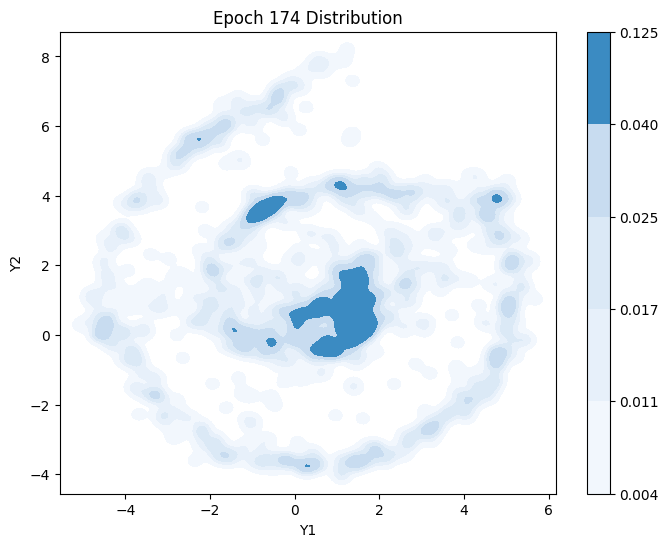

Epoch 174 - D Loss: 0.0465, G Loss: 0.2594
Mean L1 Loss per dimension: tensor([2.0467, 2.0520])
Mean L2 Loss per dimension: tensor([6.4541, 6.8708])
Epoch 175, Iter 6850, D Loss: 0.0462, G Loss: 0.2724, L1: 2.0493, L2: 6.6625
Epoch 175 - D Loss: 0.0436, G Loss: 0.2798
Mean L1 Loss per dimension: tensor([2.0273, 2.0626])
Mean L2 Loss per dimension: tensor([6.5452, 6.9082])
Epoch 176, Iter 6900, D Loss: 0.0466, G Loss: 0.2855, L1: 2.0449, L2: 6.7267
Epoch 176 - D Loss: 0.0473, G Loss: 0.2860
Epoch 177 - D Loss: 0.0527, G Loss: 0.2942
Mean L1 Loss per dimension: tensor([2.0558, 2.0497])
Mean L2 Loss per dimension: tensor([6.4517, 6.9062])
Epoch 178, Iter 6950, D Loss: 0.0368, G Loss: 0.2959, L1: 2.0527, L2: 6.6790
Epoch 178 - D Loss: 0.0400, G Loss: 0.2966
Mean L1 Loss per dimension: tensor([2.0523, 2.0296])
Mean L2 Loss per dimension: tensor([6.4594, 6.8827])
Epoch 179, Iter 7000, D Loss: 0.0391, G Loss: 0.3037, L1: 2.0410, L2: 6.6710


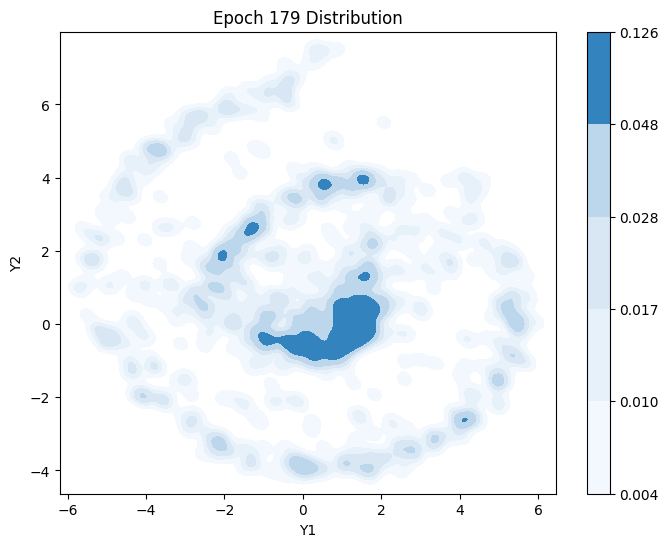

Epoch 179 - D Loss: 0.0497, G Loss: 0.2904
Mean L1 Loss per dimension: tensor([2.0189, 2.0535])
Mean L2 Loss per dimension: tensor([6.4686, 6.9402])
Epoch 180, Iter 7050, D Loss: 0.0491, G Loss: 0.2831, L1: 2.0362, L2: 6.7044
Epoch 180 - D Loss: 0.0526, G Loss: 0.2827
Epoch 181 - D Loss: 0.0504, G Loss: 0.3031
Mean L1 Loss per dimension: tensor([2.0284, 2.0580])
Mean L2 Loss per dimension: tensor([6.3803, 6.9207])
Epoch 182, Iter 7100, D Loss: 0.0541, G Loss: 0.2134, L1: 2.0432, L2: 6.6505
Epoch 182 - D Loss: 0.0492, G Loss: 0.3019
Mean L1 Loss per dimension: tensor([2.0519, 2.0440])
Mean L2 Loss per dimension: tensor([6.4841, 6.8250])
Epoch 183, Iter 7150, D Loss: 0.0426, G Loss: 0.3205, L1: 2.0480, L2: 6.6546
Epoch 183 - D Loss: 0.0459, G Loss: 0.3206
Mean L1 Loss per dimension: tensor([2.0349, 2.0452])
Mean L2 Loss per dimension: tensor([6.4708, 6.8901])
Epoch 184, Iter 7200, D Loss: 0.0519, G Loss: 0.3162, L1: 2.0401, L2: 6.6804


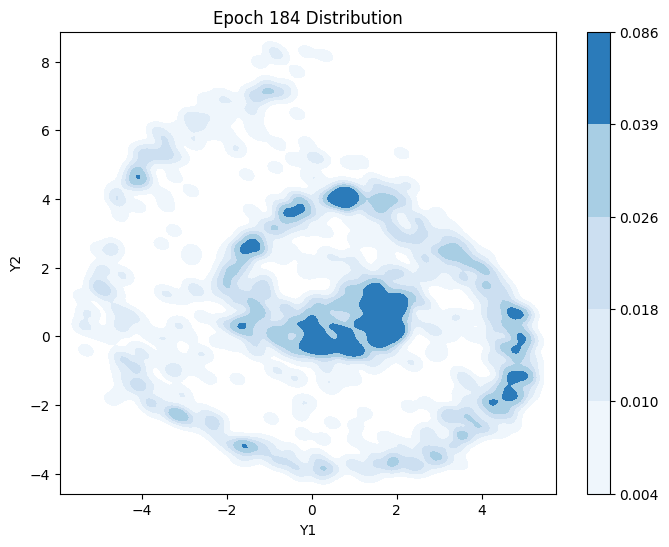

Epoch 184 - D Loss: 0.0510, G Loss: 0.3138
Mean L1 Loss per dimension: tensor([2.0329, 2.0396])
Mean L2 Loss per dimension: tensor([6.4649, 6.8173])
Epoch 185, Iter 7250, D Loss: 0.0620, G Loss: 0.2902, L1: 2.0363, L2: 6.6411
Epoch 185 - D Loss: 0.0607, G Loss: 0.2980
Epoch 186 - D Loss: 0.0534, G Loss: 0.3187
Mean L1 Loss per dimension: tensor([2.0426, 2.0250])
Mean L2 Loss per dimension: tensor([6.4378, 6.8646])
Epoch 187, Iter 7300, D Loss: 0.0515, G Loss: 0.3623, L1: 2.0338, L2: 6.6512
Epoch 187 - D Loss: 0.0516, G Loss: 0.3102
Mean L1 Loss per dimension: tensor([2.0155, 2.0622])
Mean L2 Loss per dimension: tensor([6.5592, 6.9209])
Epoch 188, Iter 7350, D Loss: 0.0522, G Loss: 0.3180, L1: 2.0389, L2: 6.7400
Epoch 188 - D Loss: 0.0462, G Loss: 0.3164
Mean L1 Loss per dimension: tensor([2.0371, 2.0672])
Mean L2 Loss per dimension: tensor([6.3729, 6.9519])
Epoch 189, Iter 7400, D Loss: 0.0482, G Loss: 0.2940, L1: 2.0521, L2: 6.6624


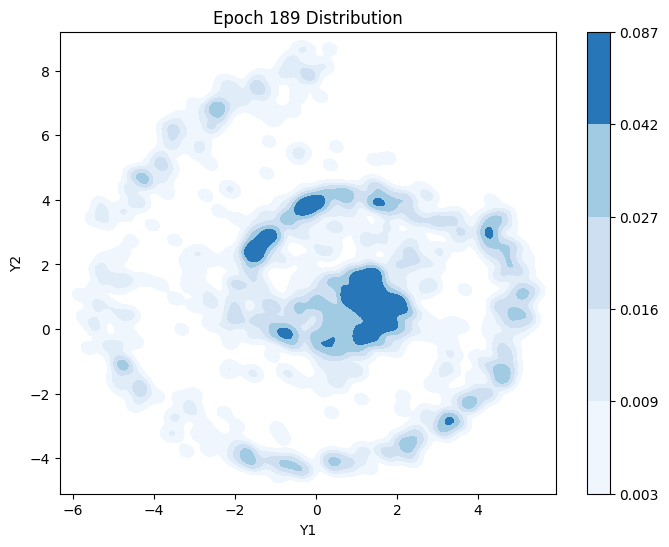

Epoch 189 - D Loss: 0.0442, G Loss: 0.2958
Epoch 190 - D Loss: 0.0483, G Loss: 0.3270
Mean L1 Loss per dimension: tensor([2.0451, 2.0414])
Mean L2 Loss per dimension: tensor([6.4135, 7.0576])
Epoch 191, Iter 7450, D Loss: 0.0352, G Loss: 0.4500, L1: 2.0433, L2: 6.7356
Epoch 191 - D Loss: 0.0529, G Loss: 0.3147
Mean L1 Loss per dimension: tensor([2.0370, 2.0220])
Mean L2 Loss per dimension: tensor([6.4152, 6.8416])
Epoch 192, Iter 7500, D Loss: 0.0636, G Loss: 0.3406, L1: 2.0295, L2: 6.6284
Epoch 192 - D Loss: 0.0656, G Loss: 0.3405
Mean L1 Loss per dimension: tensor([2.0441, 2.0412])
Mean L2 Loss per dimension: tensor([6.4277, 6.8926])
Epoch 193, Iter 7550, D Loss: 0.0541, G Loss: 0.3006, L1: 2.0426, L2: 6.6602
Epoch 193 - D Loss: 0.0529, G Loss: 0.3247
Mean L1 Loss per dimension: tensor([2.0353, 2.0373])
Mean L2 Loss per dimension: tensor([6.5147, 6.9260])
Epoch 194, Iter 7600, D Loss: 0.0622, G Loss: 0.3336, L1: 2.0363, L2: 6.7204


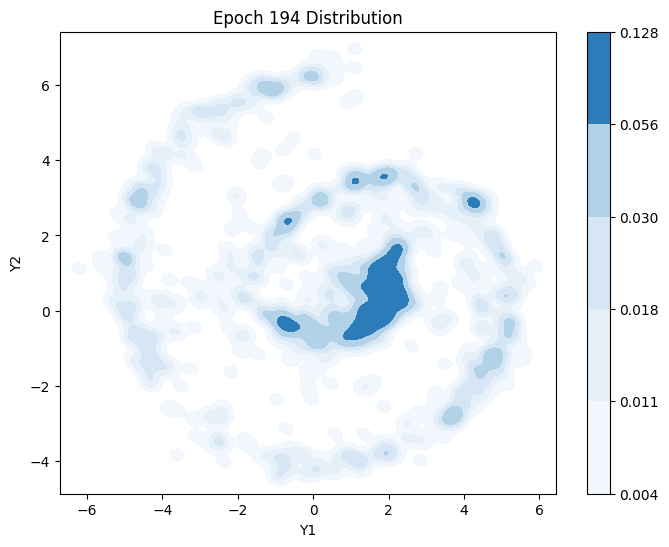

Epoch 194 - D Loss: 0.0622, G Loss: 0.3274
Epoch 195 - D Loss: 0.0504, G Loss: 0.3069
Mean L1 Loss per dimension: tensor([2.0269, 2.0279])
Mean L2 Loss per dimension: tensor([6.4714, 6.9382])
Epoch 196, Iter 7650, D Loss: 0.0529, G Loss: 0.2298, L1: 2.0274, L2: 6.7048
Epoch 196 - D Loss: 0.0591, G Loss: 0.3248
Mean L1 Loss per dimension: tensor([2.0277, 2.0318])
Mean L2 Loss per dimension: tensor([6.4214, 6.8864])
Epoch 197, Iter 7700, D Loss: 0.0796, G Loss: 0.3660, L1: 2.0298, L2: 6.6539
Epoch 197 - D Loss: 0.0628, G Loss: 0.3293
Mean L1 Loss per dimension: tensor([2.0447, 2.0442])
Mean L2 Loss per dimension: tensor([6.4634, 6.8370])
Epoch 198, Iter 7750, D Loss: 0.0536, G Loss: 0.3036, L1: 2.0444, L2: 6.6502
Epoch 198 - D Loss: 0.0540, G Loss: 0.3060
Mean L1 Loss per dimension: tensor([2.0316, 2.1000])
Mean L2 Loss per dimension: tensor([6.4356, 7.0425])
Epoch 199, Iter 7800, D Loss: 0.0575, G Loss: 0.3101, L1: 2.0658, L2: 6.7391


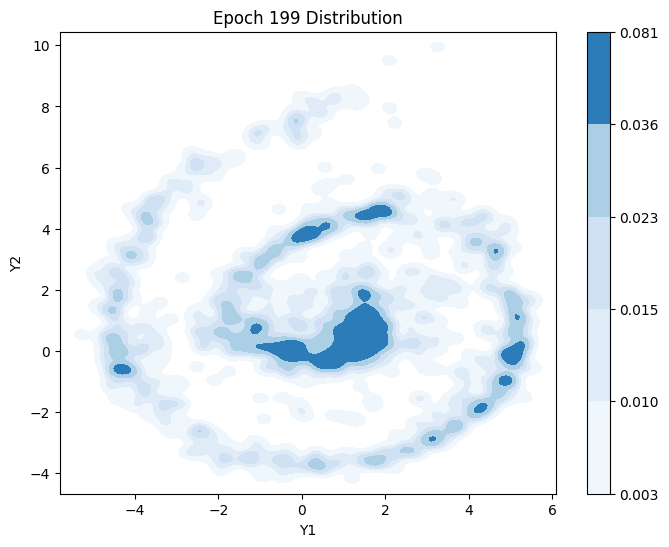

Epoch 199 - D Loss: 0.0575, G Loss: 0.3101
Saved best model with L2: 6.5820


In [10]:
# Training
trained_G, trained_D = train_WGR_fnn(D=D_net, G=G_net, D_solver=D_solver, G_solver=G_solver, 
                                     loader_train = loader_train, loader_val=loader_val,
                                     noise_dim=args.noise_dim, Xdim=args.Xdim, Ydim=args.Ydim, batch_size=args.train_batch,
                                     lambda_w=0.95,lambda_l=0.05, multivariate=True, save_path='./', 
                                     model_type=args.model, device='cpu', num_epochs=200)

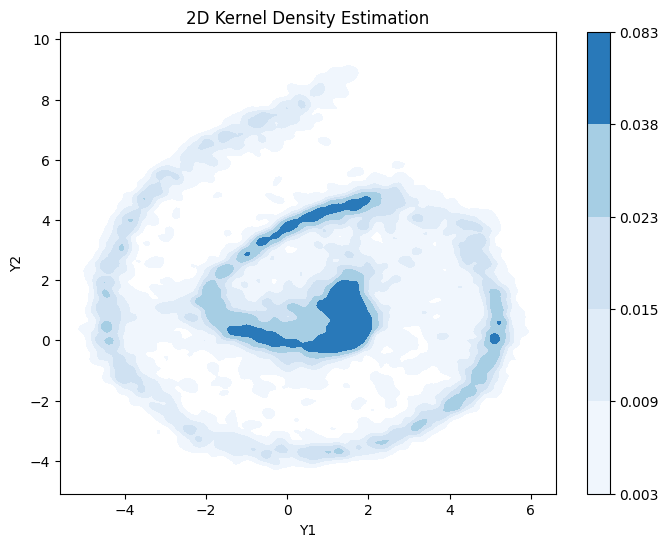

In [11]:
# Visualization for the well-trained generator 
given_X = torch.tensor([[1]]) #condition on X=1 
generate_Y = torch.zeros([10000,2]) #generate 500 response 
for i in range(10000):
    plot_eta = sample_noise(1, dim=args.noise_dim, distribution=args.noise_dist)
    plot_input =  torch.cat([given_X, plot_eta], dim=1)
    generate_Y[i] = trained_G(plot_input)
fig, ax = plot_kde_2d(generate_Y.detach(), title="2D Kernel Density Estimation")
plt.show()
plt.close()    

In [23]:
# Calculate the L1 and L2 error, MSE of conditional mean and conditional standard deviation on the test data  
test_G_mean_sd = L1L2_MSE_mean_sd_G(G = trained_G,  test_size = args.test, noise_dim=args.noise_dim, Xdim=args.Xdim,
                                    batch_size=args.test_batch,  model_type=args.model, loader_dataset = loader_test,
                                    Ydim=args.Ydim,is_multivariate=True )

Model: M3, Multivariate, Ydim: 2, J_t_size: 50
L1 Loss: tensor([2.0773, 2.1404])
L2 Loss: tensor([6.4328, 7.3865])
MSE Mean: tensor([1.8152, 1.1176])
MSE SD: tensor([0.4730, 0.4553])


In [67]:
# Calculate the MSE of conditional quantiles at different levels.
test_G_quantile = MSE_quantile_G_multiY(G = trained_G, loader_dataset = loader_test, Ydim=args.Ydim, Xdim=args.Xdim, 
                                        noise_dim=args.noise_dim,  batch_size=args.test_batch, test_size = args.test, model_type=args.model)

Quantile evaluation for model: M3, Ydim: 2
Quantile 0.05: tensor([0.2347, 0.3348])
Quantile 0.25: tensor([0.1374, 0.1032])
Quantile 0.50: tensor([0.1834, 0.0340])
Quantile 0.75: tensor([0.1180, 0.4702])
Quantile 0.95: tensor([0.1592, 1.2073])
